In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [4]:
import os
os.getcwd()


'C:\\Users\\Mikail'

In [6]:
df = pd.read_csv("data.csv", encoding="latin1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df.describe()


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
## Business Objective

The goal of this analysis is to segment customers based on purchasing behavior in order to support targeted marketing campaigns, improve customer retention, and optimize budget allocation.

In [10]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
# убираем строки без CustomerID
df = df.dropna(subset=['CustomerID'])

# переводим дату в datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# оставляем только положительные продажи
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [12]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']


In [13]:
# дата последней покупки в датасете
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [14]:
rfm.describe()


,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


In [15]:
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].copy()
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)


In [ ]:
RFM features were log-transformed and scaled to reduce skewness and ensure equal contribution to distance-based clustering.

In [18]:
sil_scores = {}

for k in range(2, 7):
    kmeans = KMeans(n_clusters= k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    sil_scores[k] = silhouette_score(rfm_scaled, labels)

sil_scores


{2: np.float64(0.4062879092024783),
 3: np.float64(0.4156517223374282),
 4: np.float64(0.3792045627020082),
 5: np.float64(0.36303453052240164),
 6: np.float64(0.3339565934336551)}

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [20]:
rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2)


,Recency,Frequency,Monetary
Cluster,,,
0,54.68,2.04,612.67
1,255.03,1.39,399.44
2,30.20,9.80,5475.75


In [ ]:
### Customer Segments

- Cluster 0: High-value loyal customers  
  Low recency, high purchase frequency, and high monetary value. Ideal for retention and upsell campaigns.

- Cluster 1: Occasional / price-sensitive customers  
  Moderate frequency and spend. Suitable for promotional and reactivation campaigns.

- Cluster 2: At-risk or churned customers  
  High recency and low engagement. Require win-back or low-cost remarketing strategies.


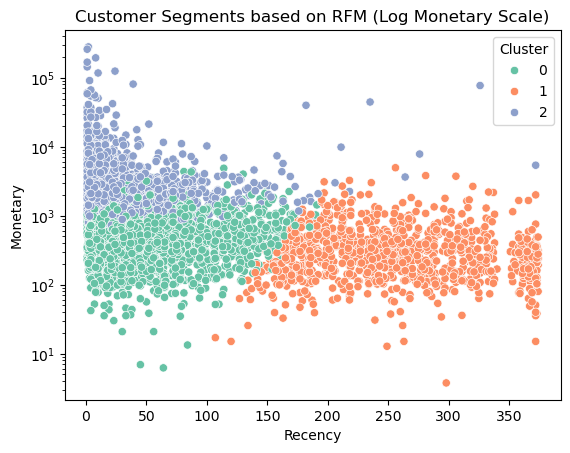

In [22]:
sns.scatterplot(
    x='Recency',
    y='Monetary',
    hue='Cluster',
    data=rfm,
    palette='Set2'
)
plt.yscale('log')
plt.title('Customer Segments based on RFM (Log Monetary Scale)')
plt.show()



In [ ]:
Cluster distribution shows a small group of high-value customers contributing a disproportionate share of revenue, which is typical in e-commerce environments.


In [23]:
rfm['Cluster'].value_counts(normalize=True).round(3)


Cluster
0    0.467
2    0.306
1    0.226
Name: proportion, dtype: float64

In [ ]:
### Key Takeaway

A small segment of loyal, high-value customers drives a disproportionate share of revenue, while a large base of low-engagement users requires cost-efficient reactivation strategies.
